#### If using AMD GPU, switch backend to PlaidML library:

In [1]:
import os
os.environ['KERAS_BACKEND']='plaidml.keras.backend'

In [2]:
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.utils import Sequence
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, ZeroPadding2D, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard
from keras_preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
import time
import pickle
from keras.models import load_model

Using plaidml.keras.backend backend.


#### Define Experiments

In [3]:
conv_layers = [5]      # number of conv layers
layer_sizes = [32]     # number of nodes in a layer
dense_layers = [2]     # number of dense layers

#### Load input data

In [6]:
pickle_in = open('../Dataset/df_all.pickle', 'rb')
df_train, df_test = pickle.load(pickle_in)

In [5]:
# The Keras ImageDataGenerator uses string type data label
df_train['gender'] = df_train.gender.astype(str)
df_test['gender'] = df_test.gender.astype(str)

In [6]:
print(df_train.shape, df_test.shape)

(429648, 10) (22613, 10)


In [7]:
df_train.dtypes

path                object
id                  uint16
name                object
dob         datetime64[ns]
gender              object
score1             float64
score2             float64
pic_date    datetime64[ns]
region              object
age                float64
dtype: object

We will be using a generator to feed model with images, the X would be the path to these images. y will be the gender label.

In [8]:
image_reshape_size = 120
input_image_root_dir = '../Dataset/imdb_crop/' # Don't forget the ending slash

In [9]:
from keras import backend as K
K.set_image_data_format('channels_last')
batch_size = 32
inputShape = (image_reshape_size, image_reshape_size, 1)

#### Set up input image generator using flow_from_dataframe

In [11]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.1)

train_generator = datagen.flow_from_dataframe(dataframe=df_train,
                                            directory=input_image_root_dir,
                                            x_col="path", y_col="gender",
                                            subset="training",
                                            class_mode="binary",
                                            color_mode="grayscale",
                                            target_size=(image_reshape_size,image_reshape_size),
                                            batch_size=batch_size,
                                            seed=1,
                                            shuffle=True)

val_generator = datagen.flow_from_dataframe(dataframe=df_train,
                                            directory=input_image_root_dir,
                                            x_col="path", y_col="gender",
                                            subset="validation",
                                            class_mode="binary",
                                            color_mode="grayscale",
                                            target_size=(image_reshape_size,image_reshape_size),
                                            batch_size=batch_size,
                                            seed=1,
                                            shuffle=True)

test_generator = datagen.flow_from_dataframe(dataframe=df_test, 
                                            directory=input_image_root_dir, 
                                            x_col="path", y_col=None, 
                                            class_mode=None, 
                                            color_mode="grayscale",
                                            target_size=(image_reshape_size,image_reshape_size),
                                            batch_size=1,
                                            shuffle=False)

Found 22613 validated image filenames.


#### Custom DataGenerator

In [19]:
class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=32, dim=(32,32,32), n_channels=1,
                 n_classes=10, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = np.load('data/' + ID + '.npy')

            # Store class
            y[i] = self.labels[ID]

        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)

In [20]:
# Parameters for data generator
params = {'dim': inputShape,
          'batch_size': batch_size,
          'n_classes': 2,
          'n_channels': 1,
          'shuffle': True}

In [ ]:
train_generator = DataGenerator()

#### (1) Run training experiments

In [ ]:
for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        for conv_layer in conv_layers:
            
            NAME = 'BN-{}-conv-{}-node-{}-dens-{}'.format(conv_layer, layer_size, dense_layer, int(time.time()))  # model name with timestamp
            print(NAME) 
            
            tensorboard = TensorBoard(log_dir='logs/{}'.format(NAME))
            callbacks = [tensorboard]
            
            model = Sequential()
            
            # first layer
            model.add(Conv2D(layer_size, (3,3), padding="same", activation="relu", input_shape=inputShape))
            model.add(BatchNormalization())
            model.add(MaxPooling2D(pool_size=(3,3)))
            
            # sets up additional # of conv layers
            for _ in range(conv_layer - 1):
                layer_size *= 2
                model.add(Conv2D(layer_size, (3,3), padding="same", activation="relu"))
                model.add(BatchNormalization())
                model.add(Conv2D(layer_size, (3,3), padding="same", activation="relu"))
                model.add(BatchNormalization())
                model.add(MaxPooling2D(pool_size=(2,2)))
                model.add(Dropout(0.25))
            
            model.add(Flatten())
            
            layer_size *= 4 # to get the dense layer to be 8X of last output size
            
            # sets up # of dense layers
            for _ in range(dense_layer):
                model.add(Dense(layer_size, activation='relu'))
                model.add(BatchNormalization())
                model.add(Dropout(0.5))
            
            # output layer
            model.add(Dense(1))
            model.add(Activation('sigmoid'))
            
            opt = Adam(lr=0.001)
            model.compile(loss='binary_crossentropy', 
                          optimizer=opt,
                          metrics=['accuracy'])

            model.fit_generator(generator=train_generator,
                                steps_per_epoch=(train_generator.n // train_generator.batch_size),
                                callbacks = callbacks,
                                validation_data=val_generator,
                                validation_steps=(val_generator.n // val_generator.batch_size),
                                epochs=10,
                                use_multiprocessing=False,
                                workers=4)
            
            filepath = NAME + '.h5'
            model.save(filepath)

#### Load model, resume training

In [4]:
inputFile = 'BN-5-conv-32-node-2-dens-1553895953.h5'
model = load_model(inputFile)

INFO:plaidml:Opening device "metal_amd_radeon_rx_vega_56.0"


In [ ]:
saveAs = 'BN-5-conv-32-node-2-dens-1553895953-4'

In [ ]:
from keras.callbacks import ModelCheckpoint

NAME = saveAs
print(NAME) 

tensorboard = TensorBoard(log_dir='logs/{}'.format(NAME))
callbacks = [tensorboard]

opt = Adam(lr=0.001)
model.compile(loss='binary_crossentropy', 
              optimizer=opt,
              metrics=['accuracy'])

model.fit_generator(generator=train_generator,
                    steps_per_epoch=(train_generator.n // train_generator.batch_size),
                    callbacks = callbacks,
                    validation_data=val_generator,
                    validation_steps=(val_generator.n // val_generator.batch_size),
                    epochs=5,
                    use_multiprocessing=True,
                    workers=4)

filepath = NAME + '.h5'
model.save(filepath)

BN-5-conv-32-node-2-dens-1553895953-4
Epoch 1/5


/Users/potatorun/anaconda3/lib/python3.6/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'
INFO:plaidml:Analyzing Ops: 88 of 1652 operations complete
INFO:plaidml:Analyzing Ops: 517 of 1652 operations complete
INFO:plaidml:Analyzing Ops: 670 of 1652 operations complete
INFO:plaidml:Analyzing Ops: 951 of 1652 operations complete


12082/12083 [============================>.] - ETA: 0s - loss: 0.4750 - acc: 0.7747

INFO:plaidml:Analyzing Ops: 92 of 259 operations complete


12083/12083 [==============================] - 3654s 302ms/step - loss: 0.4750 - acc: 0.7747 - val_loss: 0.5472 - val_acc: 0.7412
Epoch 2/5
12083/12083 [==============================] - 3885s 322ms/step - loss: 0.4929 - acc: 0.7678 - val_loss: 0.5427 - val_acc: 0.7512
Epoch 3/5
 7640/12083 [=================>............] - ETA: 25:07 - loss: 0.4922 - acc: 0.7711

#### Evaluation

In [12]:
from sklearn.metrics import confusion_matrix
test_generator.reset()
pred=model.predict_generator(test_generator,
                            steps=test_generator.n//test_generator.batch_size,
                            verbose=1)


INFO:plaidml:Analyzing Ops: 142 of 228 operations complete


22613/22613 [==============================] - 780s 34ms/step


In [13]:
y_true = df_test.gender.astype(int)
y_pred = [1 if x>=0.5 else 0 for x in pred]
cm = confusion_matrix(y_true, y_pred)

In [14]:
cm

array([[ 6128,  3257],
       [ 2244, 10984]])

In [15]:
TN = cm[0][0]
TP = cm[1][1]
FN = cm[1][0]
FP = cm[0][1]

Specificity

In [16]:
TN/(TN+FP)

0.6529568460309003

Precision

In [17]:
TP/(TP+FP)

0.771294150691665

Recall

In [18]:
TP/FN

4.894830659536542

Accuracy

In [19]:
(TP+TN)/(TN+TP+FN+FP)

0.756732852783797

In [26]:
from matplotlib import pyplot
import itertools
import math
def plotConfusionMatrix(confusionMatrix, classes, title='Confusion matrix', 
                        cmap=None, figsize=None, ylabel='True classes', xlabel='Predicted classes',
                        save=False, filepath="confusion_matrix.png"):

    if cmap is None: cmap=pyplot.cm.Reds
    if figsize is None: figsize=[7,5]

    if not ((confusionMatrix.sum(axis=1)<=1).all()==True):
        # a test dataset of only 1 datapoint will fool the above condition.
        confusionMatrix=normalizeConfusionMatrix(confusionMatrix)

    confusionMatrix=confusionMatrix*100

    fig=pyplot.figure(figsize=figsize)
    ax=fig.add_subplot(1,1,1)

    axImg=ax.imshow(confusionMatrix, cmap=cmap)
    fig.colorbar(axImg, fraction=0.046, pad=0.04)

    ax.set_title(title)

    tick_positions = np.arange(len(classes))
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(classes, rotation=45)
    ax.set_yticks(tick_positions)
    ax.set_yticklabels(classes)

    fmt = '.2f'
    threshold = (np.nanmax(confusionMatrix)+np.nanmin(confusionMatrix)) / 1.5
    r=confusionMatrix.shape[0]
    c=confusionMatrix.shape[1]

    for i, j in itertools.product(range(r), range(c)):
        ax.text(j, i, format(confusionMatrix[i, j], fmt)+"%",
                 horizontalalignment="center",
                 color="white" if (confusionMatrix[i, j] > threshold) else "black")

    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    
    fig.tight_layout()

    if save is True: fig.savefig(filepath)

    fig.show()

    return None

def normalizeConfusionMatrix(confusionMatrix):
    normConfusionMatrix = confusionMatrix.astype('float') / confusionMatrix.sum(axis=1)[:, np.newaxis]
    return normConfusionMatrix

/Users/potatorun/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


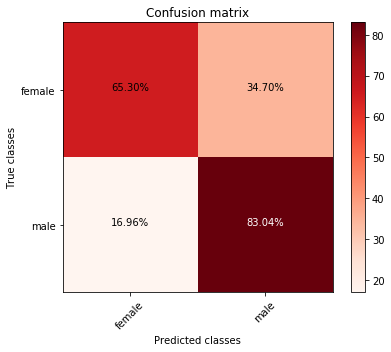

In [27]:
plotConfusionMatrix(cm, classes=["female", "male"])

#### Live Demo

In [33]:
model = load_model('BN-5-conv-32-node-2-dens-1553895953.h5')

In [25]:
def prepare(filepath):
    IMG_SIZE = image_reshape_size
    img_array = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

In [ ]:
prediction = model.predict(prepare('picture.jpg'))
print(prediction)